## Load the raw data for autoregressive models

In the previous notebook, we gained some insights on certain aspects of our data. In this notebook, we shall run the classical auto-regressive ARIMA model and see its performance.

In [28]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq/view?usp=drive_link
dataframe = pd.read_csv(r"./content/timeseries_data/raw_data.csv")
# variable_columns = ["no2", "temp", "o3", "no", "press"]
variable_column = "temp"
dataframe.shape

(576371, 5)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

In [30]:
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, n_past=24, n_future=6):
    X, y = [], []
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    for i in range(n_past, len(data) - n_future):
        window = data['datetime'].iloc[i - n_past : i + n_future]
        if not (window.diff().iloc[1:] == pd.Timedelta(hours=1)).all():
            continue # only if each step is 1 hour apart

        X.append(data[variable_column].iloc[i - n_past : i].values)
        y.append(data[variable_column].iloc[i : i + n_future].values)
    return np.array(X), np.array(y)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [31]:
## This cell could take upto 10 mins to go over 600000 time steps to generate continous samples
context_window = 336
prediction_horizon = 96 # Predict 96 steps for each variable from 24 past values

X, y = create_sequences(dataframe,context_window,prediction_horizon)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (319325, 336), y_train shape: (319325, 96)
X_test shape: (79832, 336), y_test shape: (79832, 96)


### Forecasting with MA models: SARIMAX


😈 **Task 1:** Try modeling without seasonal terms. How do AIC and RMSE compare?

😈 **Task 2:** Add an exogenous variable like `o3` into SARIMAX and observe results.

😈 **Question 1:** How does adding an exogenous variable enhance forecasting in SARIMAX?




Sample: -1 | ADF p-value: 0.7185396084063975


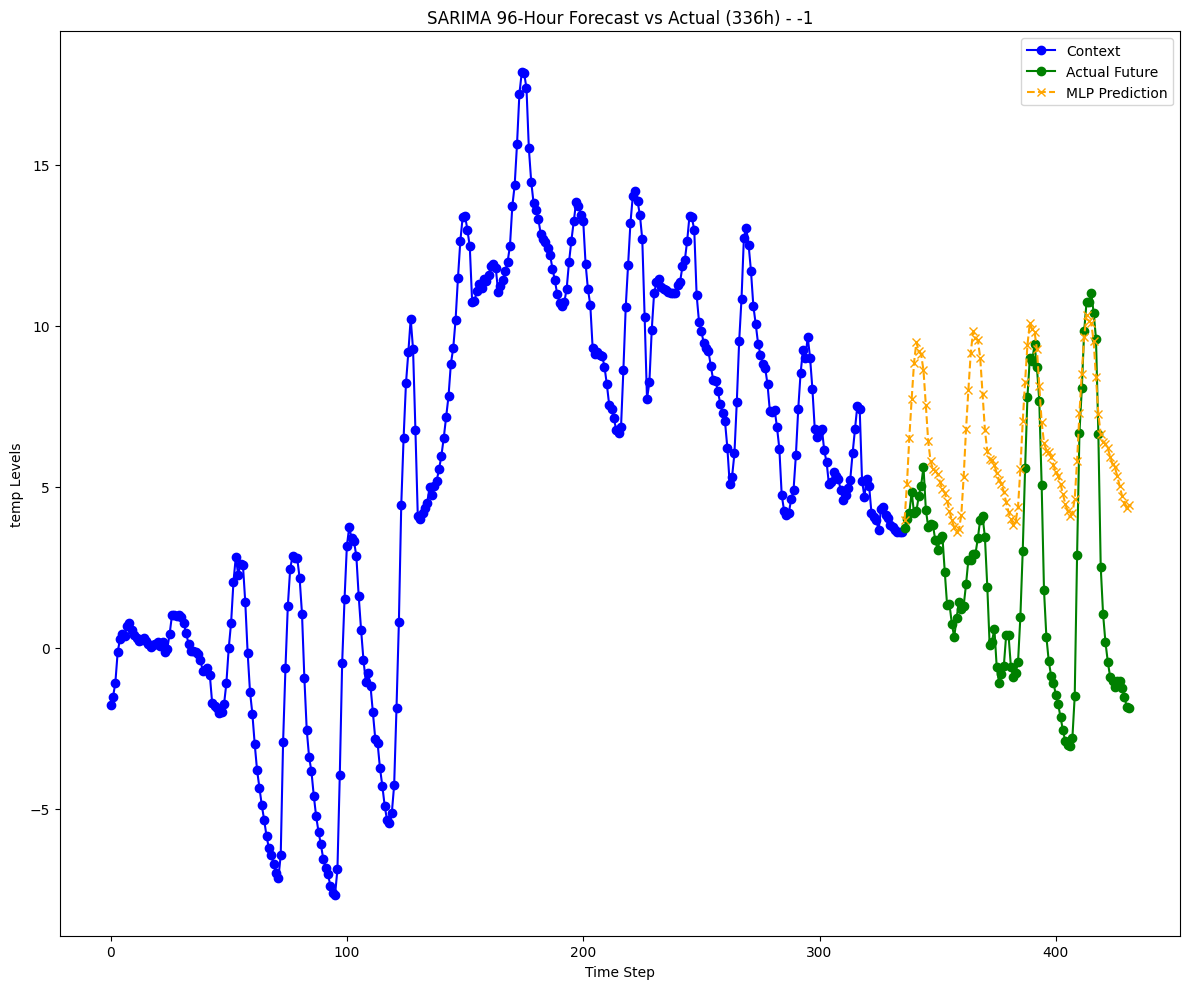

Mean Squared Error (MSE): 21.604


,SARIMA Summary
-1,SARIMAX R...


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define forecast horizon (96 hours = 4 days)
forecast_hours = 96

sarima_results = {}
sample_idx = -1

# Check stationarity using ADF test
adf_test = adfuller(X_test[sample_idx])
p_value = adf_test[1]
print(f"Sample: {sample_idx} | ADF p-value: {p_value}")

# Differencing if needed
d = 0 if p_value < 0.05 else 1  # If p-value < 0.05, it's stationary
seasonal_period = 24

# Fit SARIMA model
try:
    sarima_model = SARIMAX(X_test[sample_idx],
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False).fit()

    fitted_values = sarima_model.fittedvalues
    forecast = sarima_model.get_forecast(steps=forecast_hours)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 10))

    plt.plot(range(context_window),  X_test[sample_idx], label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), y_test[sample_idx], label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), forecast_values, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"SARIMA 96-Hour Forecast vs Actual (336h) - {sample_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("temp Levels")
    plt.legend()
    plt.tight_layout()
    plt.show()

    sarima_results[sample_idx] = sarima_model.summary()

    mse = mean_squared_error(y_test[sample_idx], forecast_values)
    print(f"Mean Squared Error (MSE): {mse:.3f}")

except Exception as e:
    sarima_results[sample_idx] = f"Error: {e}"

sarima_results_df = pd.DataFrame.from_dict(sarima_results, orient='index', columns=['SARIMA Summary'])
display(sarima_results_df)


## Data Preprocessing (Normalization)

the snippet below uses standard Z normalization (this is a simple snippet alternatively other approaches could also be used as desired)


😈 **Task 3:** Implement min-max normalization and compare the results visually with Z-score.


In [ ]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

# Global constants
TIMESERIES_DATA_DIR = "./content/timeseries_multivariate_data/"
TIMESERIES_CSV_DIR = os.path.join(TIMESERIES_DATA_DIR, "toar_csv_timeseries")
TIMESERIES_ID_FILE = os.path.join(TIMESERIES_DATA_DIR, "timeseriesIDs.json")
MIN_FILE_SIZE_BYTES = 100
group_columns = ['station_code', 'latitude', 'longitude']

os.makedirs(TIMESERIES_DATA_DIR, exist_ok=True)
os.makedirs(TIMESERIES_CSV_DIR, exist_ok=True)

In [ ]:
# German stations with good distribution o3 variable observations
station_codes = ["DENW094", "DEBW073","DEBB029","DEBE051","DEHE020"]
# station_codes = ["DENW094"]
# variable_columns = ["no2", "temp", "o3", "no", "press"]
variable_columns = ["temp"]

In [ ]:
def standard_scaler(df, columns):
    """
    Standardize the specified columns of a DataFrame by subtracting the mean
    and dividing by the standard deviation (Z-score normalization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to be normalized.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """
    df_scaled = df.copy()
    for col in columns:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = (df_scaled[col] - mean) / std
    return df_scaled

In [ ]:
dataframes = standard_scaler(dataframe, variable_columns)
dataframes.head()

,datetime,station_code,latitude,longitude,temp
0,1997-01-01 00:00:00+00:00,DEBW073,47.819182,7.567796,-2.663793
1,1997-01-01 01:00:00+00:00,DEBW073,47.819182,7.567796,-2.792464
2,1997-01-01 02:00:00+00:00,DEBW073,47.819182,7.567796,-2.792464
3,1997-01-01 03:00:00+00:00,DEBW073,47.819182,7.567796,-2.921135
4,1997-01-01 04:00:00+00:00,DEBW073,47.819182,7.567796,-2.921135


### Load the normalized data preparing samples for ML models.


> Samples are needed for sequence models and transformer models for input

😈 **Task 4:** What are some key differences between AR models and sequence models like RNNs or Transformers?

😈 **Question 2:** Why is it important to maintain time continuity when preparing samples for sequence models?



In [ ]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1Eui59GyTXNv839WijdZ0CkzuMubmZQz1/view?usp=drive_link
dataframe = pd.read_csv(r"./content/timeseries_data/normalized_data.csv")
# variable_columns = ["no2", "temp", "o3", "no", "press"]
variable_column = "temp"
dataframe.shape

(576371, 5)

80/20 train/test split chosen for illustration

😈 **Task 5:** Try a rolling-window cross-validation strategy. How does model performance vary?

😈 **Question 3:** What are the pitfalls of using random splits in timeseries forecasting?


In [ ]:
## This cell could take upto 10 mins to go over 600000 time steps to generate continous samples
context_window = 336
prediction_horizon = 96 # Predict 96 steps for each variable from 24 past values

X, y = create_sequences(dataframe,context_window,prediction_horizon)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (319325, 336), y_train shape: (319325, 96)
X_test shape: (79832, 336), y_test shape: (79832, 96)


In [ ]:
import pickle

with open("./content/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("./content/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("./content/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("./content/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Train/test datasets saved successfully.")

Train/test datasets saved successfully.


In [ ]:
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (319325, 336), y_train shape: (319325, 96)
X_test shape: (79832, 336), y_test shape: (79832, 96)
